In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def show_state(state):
    plt.subplot(1,3,1)
    plt.imshow(state[:,:,0])
    plt.title('o')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_xticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.subplot(1,3,2)
    plt.imshow(state[:,:,1])
    plt.title('x')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_xticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    plt.subplot(1,3,3)
    plt.imshow(state[:,:,2])
    plt.title('move')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_xticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

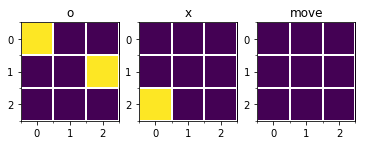

In [181]:
import numpy as np

# 1チャンネル目が○、2チャンネル目が×, 3チャンネル目が手番

board = np.zeros((3,3,3))
board[:,:,0] = 1

board = np.random.random((3,3,3))
board = board>0.8
#board[:,:,1] = board[:,:,0]-1
board[:,:,-1] = 0

show_state(board)

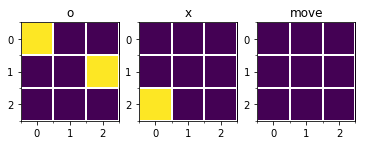

In [186]:
show_state(board)

In [50]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Flatten, Dense
from keras.models import Model

state = h = Input((3,3,3))

h = Conv2D(4, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Conv2D(4, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Flatten()(h)
value = Dense(1)(h)

value_function = Model(state, value)
value_function.compile(loss='mse', optimizer='adam')
value_function.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 4)           112       
_________________________________________________________________
batch_normalization_11 (Batc (None, 3, 3, 4)           16        
_________________________________________________________________
activation_11 (Activation)   (None, 3, 3, 4)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 4)           148       
_________________________________________________________________
batch_normalization_12 (Batc (None, 3, 3, 4)           16        
_________________________________________________________________
activation_12 (Activation)   (None, 3, 3, 4)           0         
__________

In [143]:
def get_permitted_actions(state):
    '''
    ○および×が置かれていない座標インデックスを返す。
    '''
    return np.where(state[:,:,0]+state[:,:,1]==0)

(array([0, 1, 1, 2, 2]), array([2, 0, 2, 0, 1]))


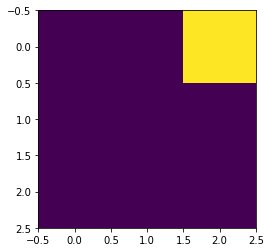

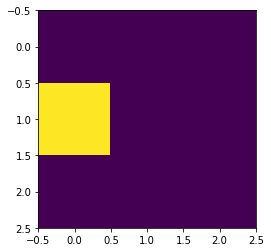

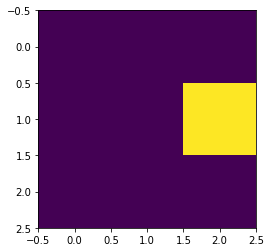

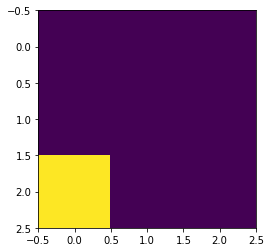

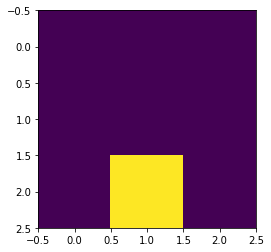

In [146]:
empties = get_permitted_actions(board)
print(empties)

for e in zip(empties[0],empties[1]):
    zeros = np.zeros((3,3))
    zeros[e] = 1
    plt.imshow(zeros)
    plt.show()

In [226]:
import copy

def transition(current_state, action):
    '''
    action は ○ もしくは × を置く state のインデックス。
    2チャンネル目が手番を表しているので、遷移後は手番を入れ替える。
    '''
    next_state = copy.deepcopy(current_state)
    if current_state[:,:,-1][0,0]==0: # ○の手番の場合
        next_state[action+(0,)] = 1
        next_state[:,:,-1] = np.ones((3,3))
    else: # ×の手番の場合
        next_state[action+(1,)] = 1
        next_state[:,:,-1] = np.zeros((3,3))
    return next_state

In [227]:
def get_best_action(current_state, value_function):
    '''
    行動空間が狭いので全探索する。
    '''
    a0,a1 = get_permitted_actions(current_state)
    max_value = 1e-100
    for action in zip(a0,a1):
        next_state = transition(current_state, action)
        next_value = value_function.predict(np.expand_dims(next_state,0)).squeeze() # バッチの次元を拡張して入力する。
        if next_value>max_value:
            max_value = next_value
            best_action = action
    return max_value, best_action

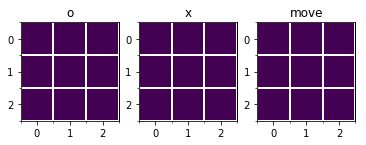

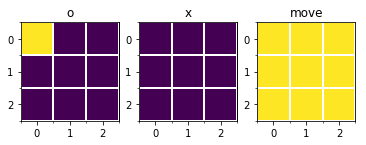

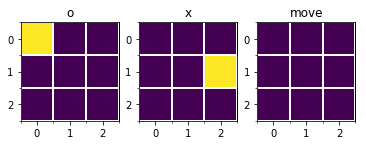

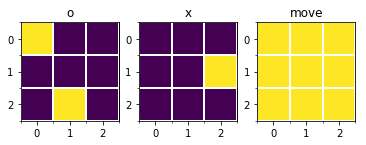

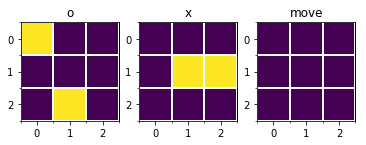

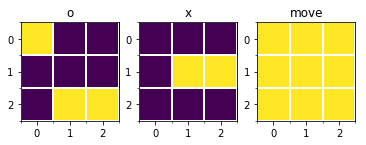

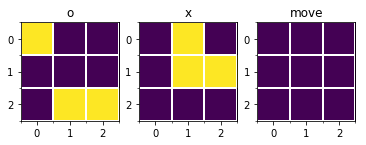

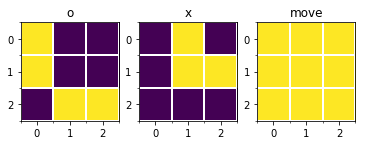

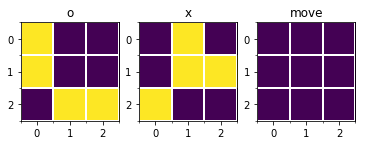

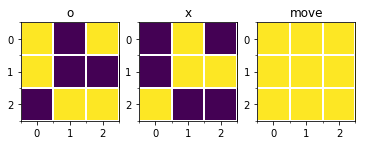

In [232]:
# 状態の初期化
current_state = np.zeros((3,3,3))
current_state[:,:,-1] = 0 # ○を先手とする。

show_state(current_state)
plt.show()

for _ in range(9):
    # 状態価値が最も高い行動を選択する。
    max_value, best_action = get_best_action(current_state, value_function)

    # 状態を更新する。
    current_state = transition(current_state, best_action)

    # 盤面の表示
    show_state(current_state)
    plt.show()
    
    # ゲームの終了判定
